In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import copy
import scipy.spatial
import cv2
import sys

from unet import UNetModel
from TSPDataset import TSPDataset
from diffusion import GaussianDiffusion
from tsp_utils import TSP_2opt, rasterize_tsp

import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
model = InferenceModel().to(device)

torch.Size([1, 50, 50])


In [23]:
points

array([[0.80172755, 0.82984265],
       [0.40353084, 0.34062357],
       [0.75483188, 0.85058066],
       [0.16019465, 0.64780491],
       [0.26001421, 0.49896135],
       [0.54942621, 0.24843942],
       [0.44346185, 0.43859186],
       [0.14160883, 0.9121662 ],
       [0.92871643, 0.18396277],
       [0.30951996, 0.03532724],
       [0.20401236, 0.76071089],
       [0.88110339, 0.8794378 ],
       [0.41087569, 0.39016365],
       [0.06339309, 0.59482519],
       [0.2212461 , 0.91187278],
       [0.51585109, 0.50272778],
       [0.68861987, 0.33063631],
       [0.52318356, 0.64734742],
       [0.14414314, 0.0904547 ],
       [0.64049827, 0.97418106],
       [0.07993152, 0.96819778],
       [0.37573494, 0.62213864],
       [0.80888501, 0.99910387],
       [0.87923738, 0.84012281],
       [0.30555198, 0.28181883],
       [0.58152741, 0.51314356],
       [0.32825618, 0.9728271 ],
       [0.25288552, 0.37874276],
       [0.7109259 , 0.82598901],
       [0.90429086, 0.59397997],
       [0.

In [34]:
edge_images = []
for i in range(points.shape[0]):
    node_edges = []
    for j in range(points.shape[0]):
        edge_img = np.zeros((img_size, img_size))
        cv2.line(edge_img, 
                    tuple(((img_size-1)*points[i,::-1]).astype(int)), 
                    tuple(((img_size-1)*points[j,::-1]).astype(int)), 
                    color=test_dataset.line_color, thickness=test_dataset.line_thickness)
        edge_img = torch.from_numpy(edge_img).float()

        node_edges.append(edge_img)
    node_edges = torch.stack(node_edges, dim=0)
    edge_images.append(node_edges)
edge_images = torch.stack(edge_images, dim=0)

In [4]:
import numpy as np
from matplotlib import pyplot as plt

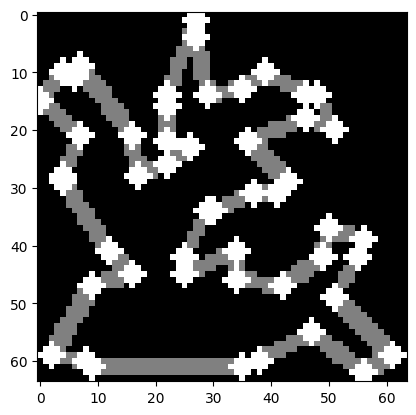

In [5]:
img = np.load('./img.npy')
plt.imshow(img[0,0], cmap='gray')
plt.show()

In [ ]:

class InferenceModel(nn.Module):
    def __init__(self):
        super(InferenceModel, self).__init__()
        
        # Latent variables (b,v,v) matrix
        self.latent = nn.Parameter(torch.randn(batch_size,points.shape[0],points.shape[0]))
        self.latent.requires_grad = True

        # Pre-compute edge images
        self.edge_images = []
        for i in range(points.shape[0]):
            node_edges = []
            for j in range(points.shape[0]):
                edge_img = np.zeros((img_size, img_size))
                cv2.line(edge_img, 
                         tuple(((img_size-1)*points[i,::-1]).astype(int)), 
                         tuple(((img_size-1)*points[j,::-1]).astype(int)), 
                         color=test_dataset.line_color, thickness=test_dataset.line_thickness)
                edge_img = torch.from_numpy(edge_img).float().to(self.latent.device)

                node_edges.append(edge_img)
            node_edges = torch.stack(node_edges, dim=0)
            self.edge_images.append(node_edges)
        self.edge_images = torch.stack(self.edge_images, dim=0)
                        
    def encode(self):
        # Compute permutation matrix
        adj_mat = normalize(self.latent)

        adj_mat_ = adj_mat
        all_edges = self.edge_images.view(1,-1,img_size,img_size).to(adj_mat.device)
        img = all_edges * adj_mat_.view(batch_size,-1,1,1)
        img = torch.sum(img, dim=1, keepdims=True)
        
        img = 2*(img-0.5)               
        
        # Draw fixed points
        img[img_query.tile(batch_size,1,1,1) == 1] = 1
        
        return img
    

def runlat(model):
    opt = torch.optim.Adam(model.parameters(), lr=1, betas=(0, 0.9))
    scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=1, end_factor=0.1, total_iters=1000)
    diffusion = GaussianDiffusion(T=1000, schedule='linear')
    # model.latent.data=temp

    steps = STEPS
    for i in range(steps):
        t = ((steps-i) + (steps-i)//3*math.cos(i/50))/steps*diffusion.T # Linearly decreasing + cosine

        t = np.clip(t, 1, diffusion.T)
        t = np.array([t for _ in range(batch_size)]).astype(int)

        # Denoise
        xt, epsilon = diffusion.sample(model.encode(), t) 
        t = torch.from_numpy(t).float().view(batch_size)
        epsilon_pred = diffusion_net(xt.float(), t.to(device))

        loss = F.mse_loss(epsilon_pred, epsilon)

        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()
        
def normalize(cost, entropy_reg=0.1, n_iters=20, eps=1e-6):
    # Cost matrix is exp(-lambda*C)
    cost_matrix = -entropy_reg * cost
        
    cost_matrix -= torch.eye(cost_matrix.shape[-1], device=cost_matrix.device)*100000
    cost_matrix = cost_matrix - torch.logsumexp(cost_matrix, dim=-1, keepdim=True)
    assignment_mat = torch.exp(cost_matrix)
    
    return assignment_mat

In [8]:
device = torch.device(f'cuda:0')
batch_size = 1
img_size = 64

test_dataset = TSPDataset(data_file=f'data/tsp50_test_concorde.txt',
                          img_size=img_size,
                          point_radius=2, point_color=1,
                          line_thickness=2, line_color=0.5)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print('Created dataset')

Loaded "data/tsp50_test_concorde.txt" with 1280 lines
Created dataset


In [9]:
diffusion_net = UNetModel(image_size=img_size, in_channels=1, out_channels=1, 
                          model_channels=64, num_res_blocks=2, channel_mult=(1,2,3,4),
                          attention_resolutions=[16,8], num_heads=4).to(device)

diffusion_net.load_state_dict(torch.load(f'models/unet50_64_8.pth'))
diffusion_net.to(device)
diffusion_net.train()
print('Loaded model')

Loaded model


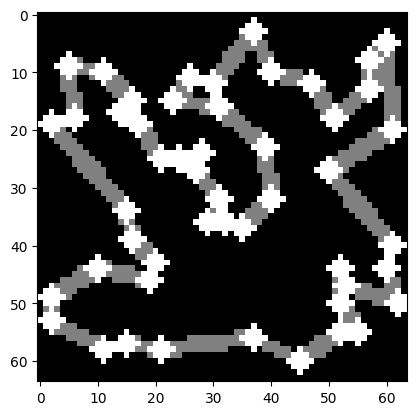

In [16]:
plt.imshow(img[0,0,:,:], cmap='gray')
plt.show()

In [14]:
STEPS=256

nn = torch.nn
costs = []
nnn = 0
for batch in test_dataloader:
    nnn += 1
    img, sample_idx = batch

    _, points, gt_tour = test_dataset.rasterize(sample_idx[0].item())

    img_query = torch.zeros_like(img)

    img_query[img == 1] = 1

    batch_idx=0
    
    model = InferenceModel().to(device)
    runlat(model)
 
    adj_mat = normalize((model.latent)).detach().cpu().numpy()[batch_idx]
    adj_mat = adj_mat+adj_mat.T

    dists = np.zeros_like(adj_mat)
    for i in range(dists.shape[0]):
        for j in range(dists.shape[0]):
            dists[i,j] = np.linalg.norm(points[i]-points[j])
    
    components = np.zeros((adj_mat.shape[0],2)).astype(int)
    components[:] = np.arange(adj_mat.shape[0])[...,None]
    real_adj_mat = np.zeros_like(adj_mat)
    for edge in (-adj_mat/dists).flatten().argsort():
        a,b = edge//adj_mat.shape[0],edge%adj_mat.shape[0]
        if not (a in components and b in components): continue
        ca = np.nonzero((components==a).sum(1))[0][0]
        cb = np.nonzero((components==b).sum(1))[0][0]
        if ca==cb: continue
        cca = sorted(components[ca],key=lambda x:x==a)
        ccb = sorted(components[cb],key=lambda x:x==b)
        newc = np.array([[cca[0],ccb[0]]])
        m,M = min(ca,cb),max(ca,cb)
        real_adj_mat[a,b] = 1
        components = np.concatenate([components[:m],components[m+1:M],components[M+1:],newc],0)
        if len(components)==1: break
    real_adj_mat[components[0,1],components[0,0]] = 1
    real_adj_mat += real_adj_mat.T
    
    tour = [0]
    while len(tour)<adj_mat.shape[0]+1:
        n = np.nonzero(real_adj_mat[tour[-1]])[0]
        if len(tour)>1:
            n = n[n!=tour[-2]]
        tour.append(n.max())

    # Refine using 2-opt
    tsp_solver = TSP_2opt(points)
    solved_tour, ns = tsp_solver.solve_2opt(tour)

    def has_duplicates(l):
        existing = []
        for item in l:
            if item in existing:
                return True
            existing.append(item)
        return False

    assert solved_tour[-1] == solved_tour[0], 'Tour not a cycle'
    assert not has_duplicates(solved_tour[:-1]), 'Tour not Hamiltonian'

    gt_cost = tsp_solver.evaluate([i-1 for i in gt_tour])
    solved_cost = tsp_solver.evaluate(solved_tour)
    print(f'Ground truth cost: {gt_cost:.3f}')
    print(f'Predicted cost: {solved_cost:.3f} (Gap: {100*(solved_cost-gt_cost) / gt_cost:.4f}%)')
    costs.append((solved_cost, gt_cost, ns))
    if nnn % 1 == 0: 
        print((solved_cost-gt_cost)/gt_cost, sum(y[0] for y in costs)/sum(y[1] for y in costs)-1, ns)
# print(costs)
# print(sum(y[0] for y in costs), sum(y[1] for y in costs), sum(y[2] for y in costs)/len(costs))